In [62]:
import torch
import gdown
import zipfile
import json
import os
import cv2
import numpy as np
import glob
import shutil
from collections import Counter
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Download Data

In [20]:
# Download TORAS Data
url = "https://drive.google.com/file/d/1eEKRSg_tK6LPMTZjn4VNtijlx6POok5T/view"
output = "labels.json"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1eEKRSg_tK6LPMTZjn4VNtijlx6POok5T
To: /content/labels.json
100%|██████████| 176M/176M [00:01<00:00, 159MB/s]


'labels.json'

In [3]:
url = "https://drive.google.com/file/d/1bhgTt0OTy7MktVIgbFml6N0fYzHHgNMI/view"
output = "batch_1.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1bhgTt0OTy7MktVIgbFml6N0fYzHHgNMI
To: /content/batch_1.zip
100%|██████████| 296M/296M [00:05<00:00, 58.7MB/s]


'batch_1.zip'

In [4]:
url = "https://drive.google.com/file/d/1iD0uRy0xcnqT9-E4ctjs9vSZnfrpDIYS/view"
output = "batch_2.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1iD0uRy0xcnqT9-E4ctjs9vSZnfrpDIYS
To: /content/batch_2.zip
100%|██████████| 162M/162M [00:03<00:00, 52.4MB/s]


'batch_2.zip'

In [5]:
with zipfile.ZipFile("batch_1.zip", "r") as f:
    f.extractall()
with zipfile.ZipFile("batch_2.zip", "r") as f:
    f.extractall()

# Convert TORAS to COCO

In [21]:
# Replace with the correct file path
file_path = "labels.json"

# Read the file and load JSON data
with open(file_path, "r") as file:
    json_data = json.load(file)

In [146]:
coco_format = {
  "info": {},
  "licenses": [],
  "categories": [{"id": 1, "name": "insect", "supercategory": "Group 1"}],
  "images": [],
  "annotations": [],
}
ann_ids = []
# Helper function to process each document
def process_document(doc, annotations, image_counter = 0):
    # Only proceed if the image file exists (check some condition here)
    image_id = int(doc['id'], 16)
    image_file_name = doc["name"]
    image_path = doc["directory"] + "/" + image_file_name
    if os.path.exists(image_path):  # Replace this condition with actual existence check
        im = cv2.imread(image_path)
        height, width = im.shape[0], im.shape[1]
          # Converting ID to integer for uniqueness
        coco_format['images'].append({
            "id": image_id,
            "file_name": doc['name'],
            "height": height,  # Replace with actual image height if available
            "width": width,   # Replace with actual image width if available
            "path": image_path
        })


    annotation_entities = annotations.get("annotationEntities", [])
    for entity in annotation_entities:
        for block in entity['annotationBlocks']:
            for ann in block['annotations']:
              # print(ann['id'])
              ann_ids.append(ann['id'])
              coco_format['annotations'].append({
                  "id": ann['id'],  # Converting ID to integer
                  "image_id": image_id,
                  "category_id": 1,  # Replace with actual category ID
                  "segmentation": ann['segments'],
                  "area": 0,  # Calculate the actual area if necessary
                  "bbox": [0, 0, 0, 0],  # Calculate the bounding box if necessary
                  "iscrowd": 0
              })

# Process each item in the input JSON
# image_counter = 0
for item in json_data:
    documents = item.get('documents', [])
    annotation = item.get('annotation', {})
    annotation_groups = annotation.get('annotationGroups', [])

    for doc in documents:
        for group in annotation_groups:
          process_document(doc, group)
          # image_counter += 1

# Save the COCO data as a JSON file
with open("coco_format_gpt4.json", "w") as f:
    json.dump(coco_format, f, indent=4)

In [148]:
coco_format['annotations'][0]

{'id': '5G5c0sOiqmlytPV',
 'image_id': 30917880719644266990776066316,
 'category_id': 1,
 'segmentation': [[[1557.2789672851563, 1068.1296874999998],
   [1556.9132080078125, 1068.8504638671875],
   [1556.7579345703125, 1069.2484130859375],
   [1557.14111328125, 1069.6534423828125],
   [1557.2288818359375, 1070.15380859375],
   [1557.678466796875, 1071.109619140625],
   [1558.1357421875, 1071.4449462890625],
   [1559.9432373046875, 1072.8438720703125],
   [1560.466796875, 1073],
   [1561.6789672851562, 1073.2296875],
   [1562.5812643963857, 1073.100555534747],
   [1563, 1072.508544921875],
   [1562.8057802654725, 1071.3537069787171],
   [1562.3789672851562, 1070.4296875],
   [1561.6789672851562, 1069.9296875],
   [1560.9789447038777, 1069.4296849009222],
   [1560.2789672851563, 1068.9296875],
   [1559.3789639700426, 1068.679699592835],
   [1558.4789672851562, 1068.4296875]]],
 'area': 0,
 'bbox': [0, 0, 0, 0],
 'iscrowd': 0}

In [133]:
ann_id_counts = Counter([i['id'] for i in coco_format['annotations']])
assert max(ann_id_counts .values()) == 1

In [96]:
def json_to_coco(json_data):
    coco_data = {
        "info": {},
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }

    category_id_map = {}
    category_id_counter = 1

    for entry in json_data:
        documents = entry.get("documents", [])
        annotations = entry.get("annotation", {})
        annotation_groups = annotations.get("annotationGroups", [])

        for document in documents:
            image_id = document["id"]
            image_file_name = document["name"]
            image_path = document["directory"] + "/" + image_file_name

            image_entry = {
                "id": image_id,
                "file_name": image_file_name,
                "path": image_path,
            }
            coco_data["images"].append(image_entry)

        for annotation_group in annotation_groups:
            if "name" in annotation_group:
                group_name = annotation_group["name"]
                # Process 'group_name' or perform any other operations with it
            else:
                # Handle the case when 'name' key is missing in the dictionary
                print("The 'name' key does not exist in the 'annotation_group' dictionary.")
            annotation_entities = annotation_group.get("annotationEntities", [])

            for entity in annotation_entities:
                category_name = entity["name"]
                category_id = category_id_map.get(category_name)
                if category_id is None:
                    category_id = category_id_counter
                    category_id_map[category_name] = category_id
                    category_id_counter += 1
                    category_entry = {
                        "id": category_id,
                        "name": category_name,
                        "supercategory": group_name
                    }
                    coco_data["categories"].append(category_entry)

                annotation_blocks = entity.get("annotationBlocks", [])
                for block in annotation_blocks:
                    if "blockId" in block:
                        annotation_id = block["blockId"]
                    else:
                        print("The 'id' key does not exist in a 'block' dictionary.")
                    # annotation_id = block["id"]
                    segmentations = block["annotations"][0]["segments"]

                    annotation_entry = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": category_id,
                        "segmentation": segmentations,
                        "iscrowd": 0
                    }
                    coco_data["annotations"].append(annotation_entry)

    return coco_data


# Replace with the correct file path
file_path = '/content/labels.json'

# Read the file and load JSON data
with open(file_path, 'r') as file:
    json_data = json.load(file)

coco_data_ = json_to_coco(json_data)

# Save the COCO data as a JSON file
with open("coco_format_vibha.json", "w") as f:
    json.dump(coco_data_, f, indent=4)

The 'name' key does not exist in the 'annotation_group' dictionary.
The 'name' key does not exist in the 'annotation_group' dictionary.
The 'name' key does not exist in the 'annotation_group' dictionary.
The 'name' key does not exist in the 'annotation_group' dictionary.
The 'name' key does not exist in the 'annotation_group' dictionary.
The 'name' key does not exist in the 'annotation_group' dictionary.
The 'name' key does not exist in the 'annotation_group' dictionary.


In [170]:
coco_data_['annotations'][-1]

{'id': '631b4ab38db152086944dc09',
 'image_id': '64026fbacc02713623d8fef2',
 'category_id': 1,
 'segmentation': [[[1932.544189453125, 124.14420318603516],
   [1933.7738037109375, 124.26332092285156],
   [1935.00341796875, 124.3824462890625],
   [1936.1934814453125, 124.62068939208984],
   [1937.109576725004, 124.9737646758141],
   [1938.4645459742396, 126.73325140117663],
   [1939.1571177368164, 127.92582316375342],
   [1940.3433807373046, 127.9757321843141],
   [1940.6734277052506, 127.9942664142817],
   [1940.84814453125, 128.2797088623047],
   [1940.8837890625, 129.43287658691406],
   [1940.93310546875, 130.41287231445312],
   [1941.2071533203125, 131.42015075683594],
   [1941.868896484375, 132.4072265625],
   [1942.939208984375, 132.9349365234375],
   [1944.0406494140625, 133.4251251220703],
   [1945.1534423828125, 133.89683532714844],
   [1946.2978515625, 134.27308654785156],
   [1947.40576171875, 134.74290466308594],
   [1948.5123291015625, 135.21287536621094],
   [1949.576538085

In [169]:
coco_format['annotations'][-1]

{'id': 'qREjVHoqrL_hUXf',
 'image_id': 30951446462248168982457155314,
 'category_id': 1,
 'segmentation': [[[1932.544189453125, 124.14420318603516],
   [1933.7738037109375, 124.26332092285156],
   [1935.00341796875, 124.3824462890625],
   [1936.1934814453125, 124.62068939208984],
   [1937.109576725004, 124.9737646758141],
   [1938.4645459742396, 126.73325140117663],
   [1939.1571177368164, 127.92582316375342],
   [1940.3433807373046, 127.9757321843141],
   [1940.6734277052506, 127.9942664142817],
   [1940.84814453125, 128.2797088623047],
   [1940.8837890625, 129.43287658691406],
   [1940.93310546875, 130.41287231445312],
   [1941.2071533203125, 131.42015075683594],
   [1941.868896484375, 132.4072265625],
   [1942.939208984375, 132.9349365234375],
   [1944.0406494140625, 133.4251251220703],
   [1945.1534423828125, 133.89683532714844],
   [1946.2978515625, 134.27308654785156],
   [1947.40576171875, 134.74290466308594],
   [1948.5123291015625, 135.21287536621094],
   [1949.5765380859375, 

# Visualize

### TORAS

In [223]:
def load_json_annotations(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return data


def draw_mask(image, mask_data, color):
    mask = np.zeros_like(image)
    segments = [
        np.array(segment, dtype=np.int32).reshape((-1, 1, 2)) for segment in mask_data
    ]
    cv2.fillPoly(mask, segments, color)
    return cv2.addWeighted(image, 1, mask, 0.5, 0)


def display_image_with_annotations(image_path, annotations, save_folder):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for annotation_group in annotations:
        annotation_blocks = annotation_group.get("annotationEntities", [])
        for block in annotation_blocks:
            segments = block.get("annotationBlocks", [])
            for segment in segments:
                if "annotations" in segment:
                    for annotation in segment["annotations"]:
                        mask_data = annotation.get("segments", [])
                        color = (0, 255, 0)  # Green color for masks, change if needed
                        image_rgb = draw_mask(image_rgb, mask_data, color)

    # Save the image with annotations
    image_name = os.path.basename(image_path)
    save_path = os.path.join(save_folder, image_name)
    if os.path.exists(save_path) is False:
      cv2.imwrite(save_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))


def visualize_annotations(json_data, image_folder, save_folder):
    for entry in json_data:
        documents = entry.get("documents", [])
        for document in documents:
            image_name = document["name"]
            image_path = os.path.join(image_folder, image_name)
            if not os.path.isfile(image_path):
                # print(f"Image not found: {image_path}")
                continue

            annotation_groups = entry.get("annotation", {}).get("annotationGroups", [])
            display_image_with_annotations(image_path, annotation_groups, save_folder)

In [ ]:
# Replace 'json_path' with the path to your JSON annotation file,
# 'image_folder' with the path to the folder containing your images,
# and 'save_folder' with the path to the folder where you want to save the visualized images.
save_folder = '/content/batch-2-imgs'
if os.path.exists(save_folder) is False:
  os.mkdir(save_folder)
for folder in [x[0] for x in os.walk("/content/batch-2")][1:]:
  print(folder)
  visualize_annotations(json_data, folder, save_folder)

### COCO

In [63]:
!pip install pycocotools -q

In [64]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

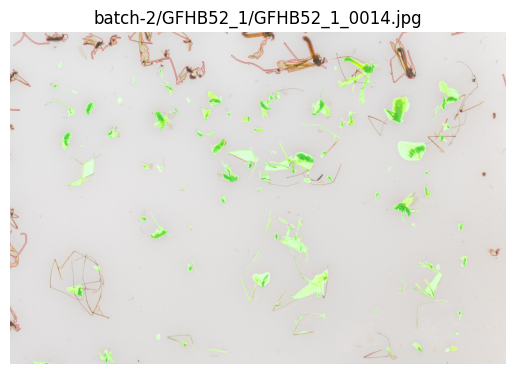

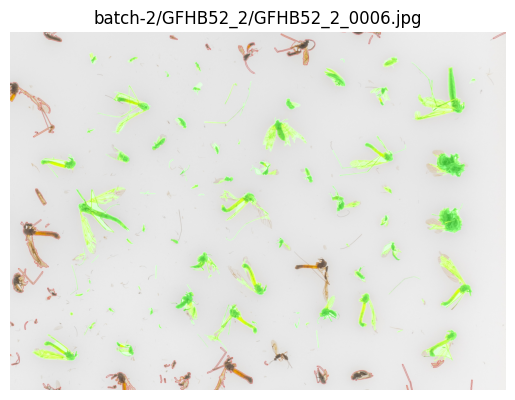

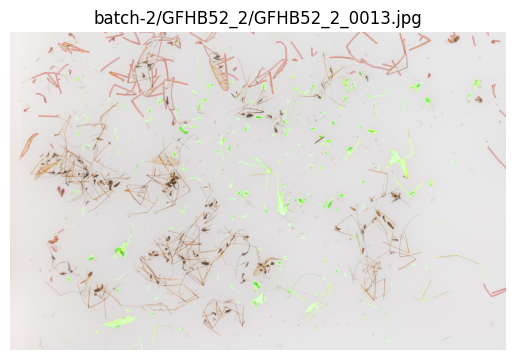

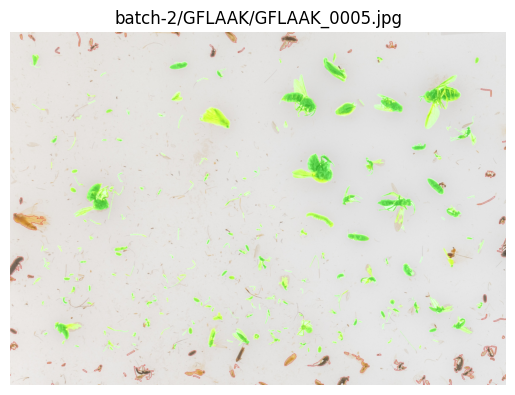

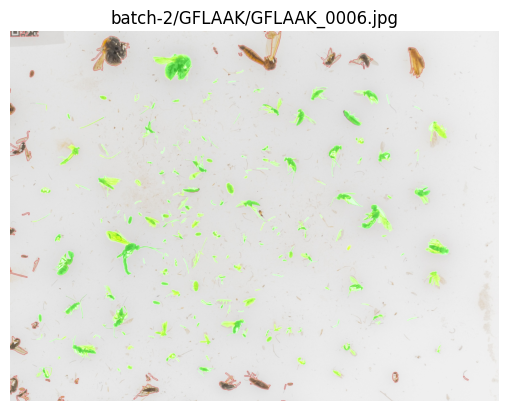

In [225]:
# Process each image
for image_info in coco_format['images'][-10:-5]:
    image_path = image_info['path']
    image_id = image_info['id']
    # image = Image.open(image_path)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotations for this image
    annotations = [ann for ann in coco_format['annotations'] if ann['image_id'] == image_id]

    # Draw each mask
    for ann in annotations:
        segmentation = [np.array(seg).reshape(-1, 2).flatten().tolist() for seg in ann['segmentation']]
        color = (0, 255, 0)
        image = draw_mask(image, segmentation, color)

    # Display the image
    plt.imshow(image)
    plt.title(image_path)
    plt.axis('off')
    plt.show()